In [22]:
import numpy as np
import matplotlib.pyplot as plt
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import seaborn as sns
import pandas as pd
from torchsummary import summary
from torch.autograd import Variable
from torch.utils.data import random_split

In [23]:
project_name='Cardano CNN model'

In [24]:
# import the dataset
raw_data = pd.read_csv('./SL Dataset/sign_mnist_train/sign_mnist_train.csv', sep=",")
raw_test_data = pd.read_csv('./SL Dataset/sign_mnist_test/sign_mnist_test.csv', sep=",")

In [25]:
train_labels = raw_data['label']
# Remove the label column
raw_data.drop('label', axis=1, inplace=True)

test_labels = raw_test_data['label']
#Remove the label column
raw_test_data.drop('label', axis=1, inplace=True)

data = raw_data.values
labels = train_labels.values
test_data = raw_test_data.values
labels_test = test_labels.values

In [26]:
set(train_labels) #9 = J and 25 = Z are excluded beacuse they are motions

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24}

<AxesSubplot:title={'center':'data[3]'}>

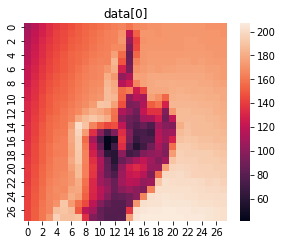

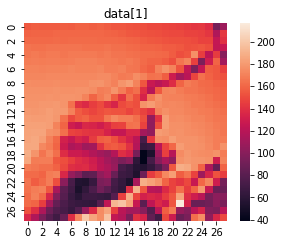

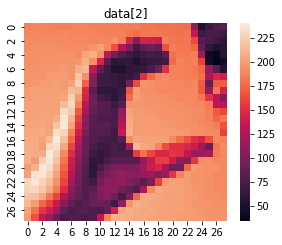

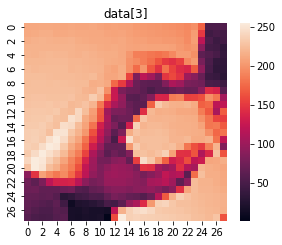

In [27]:
# Show sample images from the dataset
plt.figure(figsize = (10, 8))
dim=28
pixels = data[0].reshape(dim, dim)
plt.subplot(221); plt.title('data[0]')
sns.heatmap(data=pixels)

plt.figure(figsize = (10, 8))
pixels = data[1].reshape(dim, dim)
plt.subplot(221); plt.title('data[1]')
sns.heatmap(data=pixels)

plt.figure(figsize = (10, 8))
pixels = data[2].reshape(dim, dim)
plt.subplot(221); plt.title('data[2]')
sns.heatmap(data=pixels)

plt.figure(figsize = (10, 8))
pixels = data[3].reshape(dim, dim)
plt.subplot(221); plt.title('data[3]')
sns.heatmap(data=pixels)

In [28]:
# Create a dictionary to show output as letters
alphabet = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:"f", 6:'g',
             7:'h', 8:'i', 9:'j', 10:'k', 11:'l', 12:'m', 13:'n',
        14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 19:'t', 20:'u', 21:'v', 
             22:'w', 23:'x', 24:'y', 25:'z'}

In [29]:
# Dataset is all 1d arrays, need to reshape to 2d arrays for CNN
def reshape2D(data, dim):
    reshaped_data=[]
    for idx in data:
        reshaped_data.append(idx.reshape(1, dim, dim))
    return np.array(reshaped_data)

In [30]:
data = reshape2D(data, dim)
test_data = reshape2D(test_data, dim)

train_x = torch.FloatTensor(data)
train_y = torch.LongTensor(labels.tolist())

test_x = torch.FloatTensor(data)
test_y = torch.LongTensor(labels.tolist())

In [31]:
# DEFINE HYPERPARAMETERS!!!
batch_size = 100
Learning_Rate = 0.001
epochs = 50

In [32]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,20,3)
        self.conv3 = nn.Conv2d(20,30,3)
        
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout2d(0.2)
        
        self.fc1 = nn.Linear(30*3*3, 270)
        self.fc2 = nn.Linear(270,26)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = x.view(-1, 30 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.softmax(F.relu(self.fc2(x)))
        
        return(x)
        
    def test(self, predictions,labels):
        self.eval()
        correct = 0
        for p,l in zip(predictions,labels):
            if p==l:
                correct+=1
        acc = correct/len(predictions)
        return(acc, correct, len(predictions))
    
    def evaluate(self, predictions,labels):
        correct = 0
        for p,l in zip(predictions,labels):
            if p==l:
                correct+=1
        acc = correct/len(predictions)
        return(acc)
        

In [33]:
# Create insance of the CNN and print to check structure
model = Network()
print(model)

Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=270, out_features=270, bias=True)
  (fc2): Linear(in_features=270, out_features=26, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [34]:
# Create Loss and optimizer functions
opt_func = optim.SGD(model.parameters(), Learning_Rate, momentum=0.007)

loss_func = nn.CrossEntropyLoss()

In [35]:
# Create Trainloader and DataLoader functions for training
# def to_device(data, device):
#     """Move tensor(s) to the chosen device"""
#     if isinstance(data, (list, tuple)):
#         return [to_device(x, device) for x in data]
#     return data.to(device, non_blocking=True)

# class DeviceDataLoader():
#     """Wrap dataloader to move data to the device"""
#     def __init__(self, dl, device):
#         self.dl = dl
#         self.device = device
        
#     def __iter__(self):
#         """Yield a batch of data after moving it to device"""
#         for batch in self.dl:
#             yield to.device(batch, self.device)
            
#     def __len__(self):
#         """Number of batches"""
#         return len(self.dl)
    

In [36]:

# Move the model to the GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)

In [37]:
summary(model, (1, dim, dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
         MaxPool2d-2           [-1, 10, 13, 13]               0
            Conv2d-3           [-1, 20, 11, 11]           1,820
         MaxPool2d-4             [-1, 20, 5, 5]               0
            Conv2d-5             [-1, 30, 3, 3]           5,430
         Dropout2d-6             [-1, 30, 3, 3]               0
            Linear-7                  [-1, 270]          73,170
            Linear-8                   [-1, 26]           7,046
        LogSoftmax-9                   [-1, 26]               0
Total params: 87,566
Trainable params: 87,566
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.33
Estimated Total Size (MB): 0.43
---------------------------------------------

In [38]:
# TRAINING THE MODEL!!

loss_log = []
acc_log = []

for epoch in range(epochs):
    model.train()
    for batch in range(0, train_x.shape[0], 100):
        x_mini = train_x[batch:batch + 100]
        y_mini = train_y[batch:batch + 100]
        
        if use_cuda:
            x_mini = x_mini.cuda()
            y_mini = y_mini.cuda()
            test_x = test_x.cuda()
            test_y = test_y.cuda()
        
        opt_func.zero_grad()
        model_out = model(Variable(x_mini))
        
        loss = loss_func(model_out, Variable(y_mini))
        loss.backward()
        opt_func.step()
        
        if batch % 1000 == 0:
            loss_log.append(loss.item())
            acc_log.append(model.evaluate(torch.max(model(Variable(test_x[:500])).data, 1)[1], 
                                        test_y[:500]))
        
    print('Epoch: {} - Loss: {:.6f}'.format(epoch + 1, loss.item()))

Epoch: 1 - Loss: 2.992774
Epoch: 2 - Loss: 2.770006
Epoch: 3 - Loss: 2.596311
Epoch: 4 - Loss: 2.351685
Epoch: 5 - Loss: 2.094681
Epoch: 6 - Loss: 1.890350
Epoch: 7 - Loss: 1.862175
Epoch: 8 - Loss: 1.712421
Epoch: 9 - Loss: 1.523077
Epoch: 10 - Loss: 1.671970
Epoch: 11 - Loss: 1.441967
Epoch: 12 - Loss: 1.040327
Epoch: 13 - Loss: 1.118050
Epoch: 14 - Loss: 0.937004
Epoch: 15 - Loss: 0.935879
Epoch: 16 - Loss: 0.820779
Epoch: 17 - Loss: 0.833475
Epoch: 18 - Loss: 0.807343
Epoch: 19 - Loss: 0.662418
Epoch: 20 - Loss: 0.729815
Epoch: 21 - Loss: 0.745232
Epoch: 22 - Loss: 0.636148
Epoch: 23 - Loss: 0.669915
Epoch: 24 - Loss: 0.607516
Epoch: 25 - Loss: 0.621678
Epoch: 26 - Loss: 0.669547
Epoch: 27 - Loss: 0.648428
Epoch: 28 - Loss: 0.747496
Epoch: 29 - Loss: 0.622280
Epoch: 30 - Loss: 0.607238
Epoch: 31 - Loss: 0.614045
Epoch: 32 - Loss: 0.595056
Epoch: 33 - Loss: 0.570864
Epoch: 34 - Loss: 0.656694
Epoch: 35 - Loss: 0.625248
Epoch: 36 - Loss: 0.603721
Epoch: 37 - Loss: 0.501759
Epoch: 38 

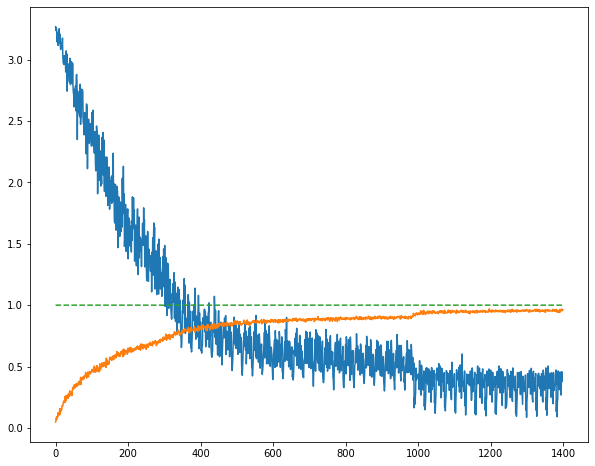

In [39]:
%matplotlib inline

plt.figure(figsize=(10,8))
plt.plot(loss_log[2:])
plt.plot(acc_log)
plt.plot(np.ones(len(acc_log)), linestyle='dashed')

In [40]:
predictions = model(Variable(test_x))
accuracy, correct, total = model.test(torch.max(predictions.data, 1)[1], test_y)

In [41]:
print("Accuracy = " + str(accuracy) + " ("+str(correct)+"/"+str(total)+")")


Accuracy = 0.9421963212529594 (25868/27455)


In [42]:
import jovian

In [43]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Committed successfully! https://jovian.ai/ayon-chakroborty/cardano-cnn


'https://jovian.ai/ayon-chakroborty/cardano-cnn'

In [46]:
jovian.log_hyperparams({
    'Num_Epochs' : epochs,
    'opt_func' : 'SGD',
    'batch_size' : batch_size,
    'LR' : Learning_Rate
})

[jovian] Hyperparams logged.


In [48]:
jovian.log_metrics({
    'accuracy' : .94
})

[jovian] Metrics logged.


In [47]:
torch.save(model, 'First_CNN_model_trained.pt')